In this notebook, I want to test a few techniques to get a simple regression model to an acceptable result.

The main question I want to find an answer to is: **how much I can improve the quality of my results in a given time?**

In all fairness, one of my problems is that I usually get too curious when I look at the data and find myself in spending a lot of time for nothing. So I thought: let's at least fail very quickly.

To this end, I decided to structure the kernel as follows:

* Define a baseline, an extremely simple model to confront my results with.
* Be a butcher, clean the data in a few minutes and start from there
* Iterate the process to find what works and what doesn't

In doing so, I will try to avoid any major pitfall one might encounter in Kaggle (the most obvious one is using the information contained in the test set to manipulate the training set). Some of those practices may lead to a better score on the Leaderboard, but in a realistic situation will never be applicable.

To be fair towards realism, I also have to say that this is not the first time I look at these data and, therefore, my eyes and mind are not fresh as they should be for a faithful experiment. After preparing the material, I am fairly sure that my previous experiments with this dataset are influential only in terms of time saved in deciding what to do with some of the features.

In preparing the process, I keep track of the cross-validated scores of each step and use that for decision making. However, since everybody likes to see a score on the leaderboard, I also produced a bunch of output data for each step so that I can trace back the progress on truly unseen data. These public results are not used in any way for decision making because, realistically, I won't have access to those data when I am building the model.


# Preparation: libraries, data, functions

Nothing fancy, I want to use Lasso and Ridge regression because they are simple enough to tune and this will save me a lot of time.

They both work well if the data are scaled, so I will make that happen in a pipeline. If I was not doing so, my cross-validation would not be trustable since the scaling would happen by seeing the entire dataset.

In a pipeline you have fewer chances of leakage.

To evaluate the model, I use the metric Kaggle suggests, with is the mean squared error and definitely a very appropriate one. In addition, only because it is easier to interpret, I will also have a look at the mean absolute error.

**NOTE**: I wanted to use ElasticNet as well, but I kept having convergence problems. Any suggestions about why it happens are welcome.

In [98]:
# standard
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import learning_curve

#machine learning
from sklearn.linear_model import Lasso, Ridge

import warnings
#warnings.filterwarnings('ignore')

In [99]:
# ---------- DF IMPORT -------------
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
combine = [df_train, df_test]
df_train.name = 'Train'
df_test.name = 'Test'

I now create my folds for the cross-validation and define my target variable.

In [100]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=14)
target = np.log1p(df_train['SalePrice'])
old_target = df_train['SalePrice']

In [101]:
def get_dollars(estimator, kfolds, data, target, old_target):
    scores = []
    train = data.copy()
    for i,(train_index, test_index) in enumerate(kfolds.split(target)):
        training = train.iloc[train_index,:]
        valid = train.iloc[test_index,:]
        tr_label = target.iloc[train_index]
        val_label = target.iloc[test_index]
        estimator.fit(training, tr_label)
        pred = estimator.predict(valid) 
        or_result = old_target.iloc[test_index]
        score = mean_absolute_error(y_pred=np.expm1(pred), y_true=or_result)
        scores.append(score)     
    return round(np.mean(scores),3)


def get_coef(clsf, ftrs):
    imp = clsf.steps[1][1].coef_.tolist() #it's a pipeline
    feats = ftrs
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

# Baseline

As a baseline, I simply use a model that takes the median of the price and uses that to predict. The following code allows me to test this idea with cross-validation.

In [102]:
scores = []
or_scores = []

for i,(train_index, test_index) in enumerate(kfolds.split(target)):
    df_train['prediction'] = np.nan
    print("Fold {} in progress".format(i))
    base = target.iloc[train_index].median()
    result = target.iloc[test_index]
    or_result = old_target.iloc[test_index]
    df_train['prediction'].iloc[test_index] = base 
    prediction = [p for p in df_train['prediction'].dropna()]
    print("Predicting with median {}".format(round(base,3)))
    score = mean_squared_error(y_pred= prediction, y_true=result)
    or_score = mean_absolute_error(y_pred=np.expm1(prediction), y_true=or_result)
    print("Scoring {}".format(score))
    print("MAE {}$".format(or_score))
    scores.append(score)
    or_scores.append(or_score)
    df_train.drop('prediction', axis=1, inplace=True)
    print("_"*40)
    
print("Baseline: {} +- {}".format(round(np.mean(scores),3), round(np.std(scores),3)))
print('MAE: {} +- {}'.format(round(np.mean(or_scores),3), round(np.std(or_scores),3)))

Fold 0 in progress
Predicting with median 11.992
Scoring 0.11220368266724205
MAE 47961.79452054796$
________________________________________
Fold 1 in progress
Predicting with median 12.008
Scoring 0.16697516374635435
MAE 56662.06849315067$
________________________________________
Fold 2 in progress
Predicting with median 12.0
Scoring 0.18938088642815337
MAE 63682.56153013264$
________________________________________
Fold 3 in progress
Predicting with median 11.995
Scoring 0.1730962881605111
MAE 58764.6712328767$
________________________________________
Fold 4 in progress
Predicting with median 12.008
Scoring 0.13835348026141692
MAE 50687.410958904096$
________________________________________
Fold 5 in progress
Predicting with median 12.008
Scoring 0.1739065814225192
MAE 56150.67122661196$
________________________________________
Fold 6 in progress


/usr/lib/python3/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Predicting with median 12.003
Scoring 0.15543355988147511
MAE 57311.52900210587$
________________________________________
Fold 7 in progress
Predicting with median 12.005
Scoring 0.16112751085624763
MAE 54591.075342465745$
________________________________________
Fold 8 in progress
Predicting with median 11.989
Scoring 0.16026214890287
MAE 59372.49315068493$
________________________________________
Fold 9 in progress
Predicting with median 12.009
Scoring 0.1731923297712694
MAE 51281.30531069406$
________________________________________
Baseline: 0.16 +- 0.021
MAE: 55646.558 +- 4427.847


This entire process took me 5 minutes, got a score of 0.16 which translates into missing the price of a house by 55000 dollars on average.

At this stage, my model would predict for every house a price of 163000 dollars, scoring a 0.41899 on Kaggle. Let's keep track of these results.

In [103]:
modelname = ['Baseline']
lassoscore = [0.16] #not true, but we need it later
ridgescore = [0.16]
kaggle_lasso = [0.41899]
kaggle_ridge = [0.41899]
timeelapsed = [600]
maecv_lasso = [55646.558]
maecv_ridge = [55646.558]

# Fast and Butchery

Just drop everything missing and go with the wind.

This is what is missing.

In [104]:
for df in combine:
    if df.name == 'Train':
        mis_train = []
        cols = df.columns
        for col in cols:
            mis = df[col].isnull().sum()
            if mis > 0:
                print("{}: {} missing, {}%".format(col, mis, round(mis/df.shape[0] * 100, 3)))
                mis_train.append(col)
        print("_"*40)
        print("_"*40)
    if df.name == 'Test':
        mis_test = []
        cols = df.columns
        for col in cols:
            mis = df[col].isnull().sum()
            if mis > 0:
                print("{}: {} missing, {}%".format(col, mis, round(mis/df.shape[0] * 100, 3)))
                mis_test.append(col)

print("\n")
print(mis_train)
print("_"*40)
print(mis_test)

LotFrontage: 259 missing, 17.74%
Alley: 1369 missing, 93.767%
MasVnrType: 8 missing, 0.548%
MasVnrArea: 8 missing, 0.548%
BsmtQual: 37 missing, 2.534%
BsmtCond: 37 missing, 2.534%
BsmtExposure: 38 missing, 2.603%
BsmtFinType1: 37 missing, 2.534%
BsmtFinType2: 38 missing, 2.603%
Electrical: 1 missing, 0.068%
FireplaceQu: 690 missing, 47.26%
GarageType: 81 missing, 5.548%
GarageYrBlt: 81 missing, 5.548%
GarageFinish: 81 missing, 5.548%
GarageQual: 81 missing, 5.548%
GarageCond: 81 missing, 5.548%
PoolQC: 1453 missing, 99.521%
Fence: 1179 missing, 80.753%
MiscFeature: 1406 missing, 96.301%
________________________________________
________________________________________
MSZoning: 4 missing, 0.274%
LotFrontage: 227 missing, 15.559%
Alley: 1352 missing, 92.666%
Utilities: 2 missing, 0.137%
Exterior1st: 1 missing, 0.069%
Exterior2nd: 1 missing, 0.069%
MasVnrType: 16 missing, 1.097%
MasVnrArea: 15 missing, 1.028%
BsmtQual: 44 missing, 3.016%
BsmtCond: 45 missing, 3.084%
BsmtExposure: 44 missi

Quite a lot, I will just drop everything, create dummies because these models require that and obtain the following.

In [105]:
butch_train = df_train[[col for col in df_test.columns if col not in mis_test]].dropna(axis=1)
butch_test = df_test[[col for col in df_test.columns if col not in mis_train]].dropna(axis=1)

butch_train.drop("Id", axis=1, inplace=True)
butch_test.drop("Id", axis=1, inplace=True)

butch_train = pd.get_dummies(butch_train)
butch_test = pd.get_dummies(butch_test)

#some of the dummies are not in both datasets (will be cured later)
butch_train = butch_train[[col for col in butch_test.columns]] 

(butch_train.columns != butch_test.columns).sum()

0

With both models I need a scaler

In [106]:
scl = ('scl', RobustScaler())

Now I make the pipeline and do some very quick grid search.

In [107]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))]) # to avoid convergence problems

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print("_"*40)
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 6.46 s, sys: 158 µs, total: 6.46 s
Wall time: 6.46 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.149927148421
________________________________________
                       params  mean_test_score  std_test_score
0    {'lasso__alpha': 0.0001}        -0.023766        0.010794
1    {'lasso__alpha': 0.0005}        -0.022478        0.010541
2   {'lasso__alpha': 0.00075}        -0.022656        0.010455
3     {'lasso__alpha': 0.001}        -0.022902        0.010391
4     {'lasso__alpha': 0.005}        -0.026135        0.010953
5    {'lasso__alpha': 0.0075}        -0.026571        0.010768
6      {'lasso__alpha': 0.01}        -0.02

In [108]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

18544.439999999999

Let's see what is getting a larger coefficient.

In [109]:
coefs = get_coef(best_lasso, butch_train.columns)
coefs.head(10)

,feat,score
2,OverallQual,0.149347
59,Neighborhood_NridgHt,0.145370
65,Neighborhood_StoneBr,0.135255
9,GrLivArea,0.120903
4,YearBuilt,0.114923
120,Heating_GasW,0.102521
49,Neighborhood_Crawfor,0.089246
103,RoofMatl_WdShngl,0.082546
58,Neighborhood_NoRidge,0.082428
64,Neighborhood_Somerst,0.071243


In [110]:
coefs.tail(10)

,feat,score
86,BldgType_TwnhsE,-0.055153
128,CentralAir_N,-0.063282
29,LotShape_IR3,-0.064284
60,Neighborhood_OldTown,-0.066770
50,Neighborhood_Edwards,-0.075373
116,Foundation_Slab,-0.080249
53,Neighborhood_MeadowV,-0.086234
85,BldgType_Twnhs,-0.115839
52,Neighborhood_IDOTRR,-0.117131
81,Condition2_PosN,-0.234605


Something makes sense, other things I can't explain but let's do the ridge regression and move on

In [111]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : [0.0001, 0.0005, 0.0075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5,
                                10, 15, 17.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 3.92 s, sys: 48 µs, total: 3.92 s
Wall time: 3.92 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.148764738684
                      params  mean_test_score  std_test_score
0   {'ridge__alpha': 0.0001}        -0.026243        0.011575
1   {'ridge__alpha': 0.0005}        -0.026236        0.011573
2   {'ridge__alpha': 0.0075}        -0.026119        0.011535
3    {'ridge__alpha': 0.001}        -0.026227        0.011570
4    {'ridge__alpha': 0.005}        -0.026160        0.011548
5   {'ridge__alpha': 0.0075}        -0.026119        0.011535
6     {'ridge__alpha': 0.01}        -0.026079        0.011522
7     {'ridge__alpha': 0.05}        -0.025532        0.011379
8    {'ridge__alpha': 0.075}    

In [112]:
dol = get_dollars(best_ridge, kfolds, butch_train, target, old_target)
dol

18327.714

In [113]:
coefs = get_coef(best_ridge, butch_train.columns)
coefs.head(10)

,feat,score
2,OverallQual,0.143794
59,Neighborhood_NridgHt,0.119654
4,YearBuilt,0.100746
65,Neighborhood_StoneBr,0.099140
9,GrLivArea,0.089436
120,Heating_GasW,0.075132
103,RoofMatl_WdShngl,0.074077
83,BldgType_2fmCon,0.073876
49,Neighborhood_Crawfor,0.073432
58,Neighborhood_NoRidge,0.069831


In [114]:
coefs.tail(10)

,feat,score
45,Neighborhood_BrDale,-0.050574
31,LandContour_Bnk,-0.055641
29,LotShape_IR3,-0.057286
116,Foundation_Slab,-0.071883
60,Neighborhood_OldTown,-0.072658
85,BldgType_Twnhs,-0.082067
81,Condition2_PosN,-0.084642
50,Neighborhood_Edwards,-0.085365
53,Neighborhood_MeadowV,-0.086901
52,Neighborhood_IDOTRR,-0.100506


In [115]:
modelname.append('Butcher')
lassoscore.append(0.1499)
ridgescore.append(0.1488)
kaggle_lasso.append(0.13321)
kaggle_ridge.append(0.13410)
timeelapsed.append(1800)
maecv_lasso.append(18544.430)
maecv_ridge.append(18327.714)

To sum up, we spent 25 more minutes, got slightly better in cross-validation (a lot better on the leaderboard, and our mean absolute error dropped of about 35000 dollars)

# Follow the documentation

If instead of dropping everything we focus on what we know from the documentation, we can use more data and get a more credible model. I talked about the topic already in this other kernel and here is the result.

First, the documentation talks about 2 outliers to be removed.

In [116]:
target = np.log1p(df_train[df_train.GrLivArea < 4500]['SalePrice'])
old_target = df_train[df_train.GrLivArea < 4500]['SalePrice']

Next, I simply do the following (I also flag the missing entries)

In [117]:
for df in combine:
    #LotFrontage
    df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = 0
    #Alley
    df.loc[df.Alley.isnull(), 'Alley'] = "NoAlley"
    #MSSubClass
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    #MissingBasement
    fil = ((df.BsmtQual.isnull()) & (df.BsmtCond.isnull()) & (df.BsmtExposure.isnull()) &
          (df.BsmtFinType1.isnull()) & (df.BsmtFinType2.isnull()))
    fil1 = ((df.BsmtQual.notnull()) | (df.BsmtCond.notnull()) | (df.BsmtExposure.notnull()) |
          (df.BsmtFinType1.notnull()) | (df.BsmtFinType2.notnull()))
    df.loc[fil1, 'MisBsm'] = 0
    df.loc[fil, 'MisBsm'] = 1
    #BsmtQual
    df.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
    #BsmtCond
    df.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
    #BsmtExposure
    df.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
    #BsmtFinType1
    df.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
    #BsmtFinType2
    df.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
    #FireplaceQu
    df.loc[(df.Fireplaces == 0) & (df.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
    #MisGarage
    fil = ((df.GarageYrBlt.isnull()) & (df.GarageType.isnull()) & (df.GarageFinish.isnull()) &
          (df.GarageQual.isnull()) & (df.GarageCond.isnull()))
    fil1 = ((df.GarageYrBlt.notnull()) | (df.GarageType.notnull()) | (df.GarageFinish.notnull()) |
          (df.GarageQual.notnull()) | (df.GarageCond.notnull()))
    df.loc[fil1, 'MisGarage'] = 0
    df.loc[fil, 'MisGarage'] = 1
    #GarageYrBlt
    df.loc[df.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
    df.loc[fil, 'GarageYrBlt'] = 0
    #GarageType
    df.loc[fil, 'GarageType'] = "NoGrg" #missing garage
    #GarageFinish
    df.loc[fil, 'GarageFinish'] = "NoGrg" #missing
    #GarageQual
    df.loc[fil, 'GarageQual'] = "NoGrg" #missing
    #GarageCond
    df.loc[fil, 'GarageCond'] = "NoGrg" #missing
    #Fence
    df.loc[df.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
    
df_test[['BsmtUnfSF', 
         'TotalBsmtSF', 
         'BsmtFinSF1', 
         'BsmtFinSF2']] = df_test[['BsmtUnfSF', 
                                   'TotalBsmtSF', 
                                   'BsmtFinSF1', 
                                   'BsmtFinSF2']].fillna(0) #checked

After this operation, we are left with the following missing entries

In [118]:
for df in combine:
    if df.name == 'Train':
        mis_train = []
        cols = df.columns
        for col in cols:
            mis = df[col].isnull().sum()
            if mis > 0:
                print("{}: {} missing, {}%".format(col, mis, round(mis/df.shape[0] * 100, 3)))
                mis_train.append(col)
        print("_"*40)
        print("_"*40)
    if df.name == 'Test':
        mis_test = []
        cols = df.columns
        for col in cols:
            mis = df[col].isnull().sum()
            if mis > 0:
                print("{}: {} missing, {}%".format(col, mis, round(mis/df.shape[0] * 100, 3)))
                mis_test.append(col)

print("\n")
print(mis_train)
print("_"*40)
print(mis_test)

MasVnrType: 8 missing, 0.548%
MasVnrArea: 8 missing, 0.548%
BsmtExposure: 1 missing, 0.068%
BsmtFinType2: 1 missing, 0.068%
Electrical: 1 missing, 0.068%
PoolQC: 1453 missing, 99.521%
MiscFeature: 1406 missing, 96.301%
________________________________________
________________________________________
MSZoning: 4 missing, 0.274%
Utilities: 2 missing, 0.137%
Exterior1st: 1 missing, 0.069%
Exterior2nd: 1 missing, 0.069%
MasVnrType: 16 missing, 1.097%
MasVnrArea: 15 missing, 1.028%
BsmtQual: 2 missing, 0.137%
BsmtCond: 3 missing, 0.206%
BsmtExposure: 2 missing, 0.137%
BsmtFullBath: 2 missing, 0.137%
BsmtHalfBath: 2 missing, 0.137%
KitchenQual: 1 missing, 0.069%
Functional: 2 missing, 0.137%
GarageYrBlt: 2 missing, 0.137%
GarageFinish: 2 missing, 0.137%
GarageCars: 1 missing, 0.069%
GarageArea: 1 missing, 0.069%
GarageQual: 2 missing, 0.137%
GarageCond: 2 missing, 0.137%
PoolQC: 1456 missing, 99.794%
MiscFeature: 1408 missing, 96.504%
SaleType: 1 missing, 0.069%


['MasVnrType', 'MasVnrArea'

In other words, we have a few more features to feed our models with. Let's do this iteration before doing anything else.

In [119]:
butch_train = df_train[[col for col in df_test.columns if col not in mis_test]].dropna(axis=1)
butch_test = df_test[[col for col in df_test.columns if col not in mis_train]].dropna(axis=1)

butch_train.drop("Id", axis=1, inplace=True)
butch_test.drop("Id", axis=1, inplace=True)

butch_train = pd.get_dummies(butch_train)
butch_test = pd.get_dummies(butch_test)

butch_train = butch_train[[col for col in butch_test.columns if col in butch_train.columns]]
butch_test = butch_test[[col for col in butch_train.columns]]

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoGrg' in col], axis = 1) #because redundant with MisGarage
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoGrg' in col], axis = 1)

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoBsmt' in col], axis = 1) #because redundant with MisBsm
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoBsmt' in col], axis = 1)

butch_train = butch_train[butch_train.GrLivArea < 4500] #according to documentation
df_train = df_train[df_train.GrLivArea < 4500] #for consistency

(butch_train.columns != butch_test.columns).sum()

0

In [120]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 8.84 s, sys: 152 µs, total: 8.84 s
Wall time: 8.84 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.118594343115
                       params  mean_test_score  std_test_score
0    {'lasso__alpha': 0.0001}        -0.014637        0.003781
1    {'lasso__alpha': 0.0005}        -0.014065        0.003455
2   {'lasso__alpha': 0.00075}        -0.014117        0.003462
3     {'lasso__alpha': 0.001}        -0.014257        0.003485
4     {'lasso__alpha': 0.005}        -0.017218        0.003997
5    {'lasso__alpha': 0.0075}        -0.018302        0.004218
6      {'lasso__alpha': 0.01}        -0.019054        0.004373
7      {'lasso__alph

In [121]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

14411.228999999999

In [122]:
coefs = get_coef(best_lasso, butch_train.columns)
coefs.head(10)

,feat,score
13,GrLivArea,0.164085
2,OverallQual,0.116486
4,YearBuilt,0.114190
89,Neighborhood_StoneBr,0.089362
73,Neighborhood_Crawfor,0.087776
185,SaleCondition_Partial,0.082644
83,Neighborhood_NridgHt,0.072181
6,BsmtFinSF1,0.070445
88,Neighborhood_Somerst,0.058681
9,TotalBsmtSF,0.055189


In [123]:
coefs.tail(10)

,feat,score
76,Neighborhood_IDOTRR,-0.031973
109,BldgType_Twnhs,-0.037201
84,Neighborhood_OldTown,-0.041434
97,Condition1_RRAe,-0.043550
158,CentralAir_N,-0.047167
180,SaleCondition_Abnorml,-0.048451
36,MSSubClass_30,-0.050491
77,Neighborhood_MeadowV,-0.068868
30,MisGarage,-0.071672
32,MSSubClass_160,-0.083747


Both the absolute mean error and the mean squared error are dropping.

In [124]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : [0.0001, 0.0005, 0.0075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5,
                                10, 15, 17.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 6.06 s, sys: 158 µs, total: 6.06 s
Wall time: 6.06 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=17.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.118488712056
                      params  mean_test_score  std_test_score
0   {'ridge__alpha': 0.0001}        -0.016165        0.004024
1   {'ridge__alpha': 0.0005}        -0.016162        0.004024
2   {'ridge__alpha': 0.0075}        -0.016124        0.004024
3    {'ridge__alpha': 0.001}        -0.016160        0.004024
4    {'ridge__alpha': 0.005}        -0.016138        0.004024
5   {'ridge__alpha': 0.0075}        -0.016124        0.004024
6     {'ridge__alpha': 0.01}        -0.016111        0.004024
7     {'ridge__alpha': 0.05}        -0.015939        0.004024
8    {'ridge__alpha': 0.075} 

In [125]:
dol = get_dollars(best_ridge, kfolds, butch_train, target, old_target)
dol

14495.808999999999

In [126]:
coefs = get_coef(best_ridge, butch_train.columns)
coefs.head(10)

,feat,score
2,OverallQual,0.109998
13,GrLivArea,0.097107
4,YearBuilt,0.094937
9,TotalBsmtSF,0.066583
185,SaleCondition_Partial,0.065824
73,Neighborhood_Crawfor,0.064149
89,Neighborhood_StoneBr,0.059683
83,Neighborhood_NridgHt,0.055523
6,BsmtFinSF1,0.053968
11,2ndFlrSF,0.052177


In [127]:
coefs.tail(10)

,feat,score
74,Neighborhood_Edwards,-0.035187
76,Neighborhood_IDOTRR,-0.035630
97,Condition1_RRAe,-0.036696
109,BldgType_Twnhs,-0.041724
84,Neighborhood_OldTown,-0.045916
36,MSSubClass_30,-0.047569
180,SaleCondition_Abnorml,-0.053540
77,Neighborhood_MeadowV,-0.053929
32,MSSubClass_160,-0.056054
30,MisGarage,-0.056067


In [128]:
modelname.append('Doc_Impute')
lassoscore.append(0.1186)
ridgescore.append(0.1185)
kaggle_lasso.append(0.11980)
kaggle_ridge.append(0.11974)
timeelapsed.append(9000)
maecv_lasso.append(14411.229)
maecv_ridge.append(14495.809)

# Full imputation

With this I mean the following:

* drop columns that I know are problematic already
* drop every entry with a missing value in the train dataset, because I don't want to reinforce existing patterns
* since I can't do the same on the test set or Kaggle will punish me, I impute with mean or medians the missing colums

In [129]:
print(df_train.shape, df_test.shape)
df_train.drop("PoolQC", axis=1, inplace = True) #I know these are going to be missing always and I don't care
df_train.drop("MiscFeature", axis=1, inplace = True)
df_test.drop("PoolQC", axis=1, inplace = True)
df_test.drop("MiscFeature", axis=1, inplace = True)
print(df_train.shape, df_test.shape)

(1458, 83) (1459, 82)
(1458, 81) (1459, 80)


/home/lucabasa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lucabasa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Now I drop the missing values in the training set

**Note**: if the number of problematic entries was higher, I would test several imputers inside of the pipeline right before the scaler. In this way, I would have a trustable comparison between different models. Imputing outside of the pipeline would use the information of the entire dataset and, thus, would make my cross-validation less trustable.

In [130]:
print("Size of train set before my butchering: {}".format(df_train.shape))
for f in df_train.columns:
    df_train = df_train[pd.notnull(df_train[f])]

cols = df_train.columns
print("Start printing the missing values...")
mis_train = []
for col in cols:
    mis = df_train[col].isnull().sum()
    if mis > 0:
        print("{}: {} missing, {}%".format(col, mis, round(mis/df_train.shape[0] * 100, 3)))
        mis_train.append(col)
print("...done printing the missing values")
print(mis_train)
print("Size of train set after my butchering: {}".format(df_train.shape))

Size of train set before my butchering: (1458, 81)
Start printing the missing values...
...done printing the missing values
[]
Size of train set after my butchering: (1447, 81)


They won't be missed so much after all.

Next, a few functions to help me for the imputation of the test. The idea is to use mean and median taken not from the entire set but rather from the similar entries.

In [131]:
#To find the segment of the missing values, can be useful to impute the missing values
def find_segment(df, feat): 
    mis = df[feat].isnull().sum()
    cols = df.columns
    seg = []
    for col in cols:
        vc = df[df[feat].isnull()][col].value_counts(dropna=False).iloc[0]
        if (vc == mis): #returns the columns for which the missing entries have only 1 possible value
            seg.append(col)
    return seg

# to find the mode of the missing feature, by choosing the right segment to compare (uses find_segment)
def find_mode(df, feat): #returns the mode to fill in the missing feat
    md = df[df[feat].isnull()][find_segment(df, feat)].dropna(axis = 1).mode()
    md = pd.merge(df, md, how='inner')[feat].mode().iloc[0]
    return md

# identical to the previous one, but with the median
def find_median(df, feat): #returns the median to fill in the missing feat
    md = df[df[feat].isnull()][find_segment(df, feat)].dropna(axis = 1).mode()
    md = pd.merge(df, md, how='inner')[feat].median()
    return md

# find the mode in a segment defined by the user
def similar_mode(df, col, feats): #returns the mode in a segment made by similarity in feats
    sm = df[df[col].isnull()][feats]
    md = pd.merge(df, sm, how='inner')[col].mode().iloc[0]
    return md

# Find the median in a segment defined by the user
def similar_median(df, col, feats): #returns the median in a segment made by similarity in feats
    sm = df[df[col].isnull()][feats]
    md = pd.merge(df, sm, how='inner')[col].median()
    return md

In [132]:
#MSZoning
md = find_mode(df_test, 'MSZoning')
print("MSZoning {}".format(md))
df_test[['MSZoning']] = df_test[['MSZoning']].fillna(md)
#Utilities
md = 'AllPub'
df_test[['Utilities']] = df_test[['Utilities']].fillna(md)
#MasVnrType
md = find_mode(df_test, 'MasVnrType')
print("MasVnrType {}".format(md))
df_test[['MasVnrType']] = df_test[['MasVnrType']].fillna(md)
#MasVnrArea
md = find_mode(df_test, 'MasVnrArea')
print("MasVnrArea {}".format(md))
df_test[['MasVnrArea']] = df_test[['MasVnrArea']].fillna(md)
#BsmtQual
simi = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
md = similar_mode(df_test, 'BsmtQual', simi)
print("BsmtQual {}".format(md))
df_test[['BsmtQual']] = df_test[['BsmtQual']].fillna(md)
#BsmtCond
simi = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
md = similar_mode(df_test, 'BsmtCond', simi)
print("BsmtCond {}".format(md))
df_test[['BsmtCond']] = df_test[['BsmtCond']].fillna(md)
#BsmtCond
simi = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
md = similar_mode(df_test, 'BsmtExposure', simi)
print("BsmtExposure {}".format(md))
df_test[['BsmtExposure']] = df_test[['BsmtExposure']].fillna(md)
#BsmtFullBath
simi = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
md = similar_median(df_test, 'BsmtFullBath', simi)
print("BsmtFullBath {}".format(md))
df_test[['BsmtFullBath']] = df_test[['BsmtFullBath']].fillna(md)
#BsmtHalfBath
simi = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
md = similar_median(df_test, 'BsmtHalfBath', simi)
print("BsmtHalfBath {}".format(md))
df_test[['BsmtHalfBath']] = df_test[['BsmtHalfBath']].fillna(md)
#KitchenQual
md = df_test.KitchenQual.mode().iloc[0]
print("KitchenQual {}".format(md))
df_test[['KitchenQual']] = df_test[['KitchenQual']].fillna(md)
#Functional
md = 'Typ'
df_test[['Functional']] = df_test[['Functional']].fillna(md)
#GarageYrBlt
simi = ['GarageType', 'MisGarage']
md = similar_median(df_test, 'GarageYrBlt', simi)
print("GarageYrBlt {}".format(md))
df_test[['GarageYrBlt']] = df_test[['GarageYrBlt']].fillna(md)
#GarageFinish
md = 'Unf'
print("GarageFinish {}".format(md))
df_test[['GarageFinish']] = df_test[['GarageFinish']].fillna(md)
#GarageArea
simi = ['GarageType', 'MisGarage']
md = similar_median(df_test, 'GarageArea', simi)
print("GarageArea {}".format(md))
df_test[['GarageArea']] = df_test[['GarageArea']].fillna(md)
#GarageQual
simi = ['GarageType', 'MisGarage', 'GarageFinish']
md = similar_mode(df_test, 'GarageQual', simi)
print("GarageQual {}".format(md))
df_test[['GarageQual']] = df_test[['GarageQual']].fillna(md)
#GarageCond
simi = ['GarageType', 'MisGarage', 'GarageFinish']
md = similar_mode(df_test, 'GarageCond', simi)
print("GarageCond {}".format(md))
df_test[['GarageCond']] = df_test[['GarageCond']].fillna(md)
#GarageCars
simi = ['GarageType', 'MisGarage']
md = similar_median(df_test, 'GarageCars', simi)
print("GarageCars {}".format(md))
df_test[['GarageCars']] = df_test[['GarageCars']].fillna(md)

cols = df_test.columns
mis_test = []
print("Start printing the missing values...")
for col in cols:
    mis = df_test[col].isnull().sum()
    if mis > 0:
        print("{}: {} missing, {}%".format(col, mis, round(mis/df_test.shape[0] * 100, 3)))
        mis_test.append(col)
print("...done printing the missing values")

MSZoning RM
MasVnrType None
MasVnrArea 0.0
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFullBath 0.0
BsmtHalfBath 0.0
KitchenQual TA
GarageYrBlt 1959.0
GarageFinish Unf
GarageArea 384.0
GarageQual TA
GarageCond TA
GarageCars 1.0
Start printing the missing values...
Exterior1st: 1 missing, 0.069%
Exterior2nd: 1 missing, 0.069%
SaleType: 1 missing, 0.069%
...done printing the missing values


Not much left, I don't want to think about it anymore. Let's run this new iteration.

In [133]:
butch_train = df_train[[col for col in df_test.columns if col not in mis_test]].dropna(axis=1)
butch_test = df_test[[col for col in df_test.columns if col not in mis_train]].dropna(axis=1)

butch_train.drop("Id", axis=1, inplace=True)
butch_test.drop("Id", axis=1, inplace=True)

butch_train = pd.get_dummies(butch_train)
butch_test = pd.get_dummies(butch_test)

print(list(set(butch_train.columns) - set(butch_test.columns)))

butch_train = butch_train[[col for col in butch_test.columns if col in butch_train.columns]]
butch_test = butch_test[[col for col in butch_train.columns]]

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoGrg' in col], axis = 1) #because redundant with MisGarage
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoGrg' in col], axis = 1)

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoBsmt' in col], axis = 1) #because redundant with MisBsm
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoBsmt' in col], axis = 1)

butch_train = butch_train[butch_train.GrLivArea < 4500] #according to documentation
target = np.log1p(df_train[df_train.GrLivArea < 4500]['SalePrice']) #for consistency
old_target = df_train[df_train.GrLivArea < 4500]['SalePrice']

(butch_train.columns != butch_test.columns).sum()

['GarageQual_Ex', 'Heating_OthW', 'HouseStyle_2.5Fin', 'Condition2_RRNn', 'RoofMatl_Membran', 'Condition2_RRAn', 'Condition2_RRAe', 'RoofMatl_Roll', 'Heating_Floor', 'Electrical_Mix', 'Utilities_NoSeWa', 'RoofMatl_Metal']


0

Quite a few dummies are not in both datasets, I will deal with that later.

In [134]:
butch_train.shape

(1447, 247)

In [135]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 12 s, sys: 142 µs, total: 12 s
Wall time: 12 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.111532901469
                       params  mean_test_score  std_test_score
0    {'lasso__alpha': 0.0001}        -0.013135        0.002903
1    {'lasso__alpha': 0.0005}        -0.012440        0.002941
2   {'lasso__alpha': 0.00075}        -0.012466        0.002915
3     {'lasso__alpha': 0.001}        -0.012700        0.002930
4     {'lasso__alpha': 0.005}        -0.016119        0.002881
5    {'lasso__alpha': 0.0075}        -0.017017        0.002876
6      {'lasso__alpha': 0.01}        -0.017818        0.002993
7      {'lasso__alpha': 0.

In [136]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

13250.529

In [137]:
coefs = get_coef(best_lasso, butch_train.columns)
coefs.head(10)

,feat,score
14,GrLivArea,0.160342
85,Neighborhood_Crawfor,0.106036
2,OverallQual,0.098442
4,YearBuilt,0.081835
246,SaleCondition_Partial,0.076662
101,Neighborhood_StoneBr,0.062206
198,KitchenQual_Ex,0.059004
10,TotalBsmtSF,0.054974
208,Functional_Typ,0.053024
53,MSZoning_FV,0.050663


In [138]:
coefs.tail(10)

,feat,score
178,BsmtFinType2_BLQ,-0.021136
20,KitchenAbvGr,-0.027242
203,Functional_Maj2,-0.033007
56,MSZoning_RM,-0.039634
38,MSSubClass_160,-0.043721
241,SaleCondition_Abnorml,-0.045277
42,MSSubClass_30,-0.048651
192,CentralAir_N,-0.055531
89,Neighborhood_MeadowV,-0.069975
52,MSZoning_C (all),-0.184767


In [139]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5,
                                10, 15, 17.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 9.94 s, sys: 4.03 ms, total: 9.94 s
Wall time: 9.94 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.112506765279
                       params  mean_test_score  std_test_score
0    {'ridge__alpha': 0.0001}        -0.015293        0.003892
1    {'ridge__alpha': 0.0005}        -0.015288        0.003887
2   {'ridge__alpha': 0.00075}        -0.015285        0.003884
3     {'ridge__alpha': 0.001}        -0.015282        0.003881
4     {'ridge__alpha': 0.005}        -0.015234        0.003834
5    {'ridge__alpha': 0.0075}        -0.015206        0.003807
6      {'ridge__alpha': 0.01}        -0.015179        0.003782
7      {'ridge__alpha': 0.05}        -0.014866        0.003526
8     {'ridge__alpha'

In [140]:
dol = get_dollars(best_ridge, kfolds, butch_train, target, old_target)
dol

13383.857

In [141]:
coefs = get_coef(best_ridge, butch_train.columns)
coefs.head(10)

,feat,score
14,GrLivArea,0.095998
2,OverallQual,0.090974
85,Neighborhood_Crawfor,0.079565
4,YearBuilt,0.066731
246,SaleCondition_Partial,0.058067
208,Functional_Typ,0.054646
101,Neighborhood_StoneBr,0.054462
10,TotalBsmtSF,0.053805
12,2ndFlrSF,0.050723
53,MSZoning_FV,0.048540


In [142]:
coefs.tail(10)

,feat,score
121,BldgType_Twnhs,-0.030498
192,CentralAir_N,-0.030735
86,Neighborhood_Edwards,-0.032951
185,Heating_Grav,-0.033896
42,MSSubClass_30,-0.035913
203,Functional_Maj2,-0.041364
38,MSSubClass_160,-0.044063
241,SaleCondition_Abnorml,-0.054887
89,Neighborhood_MeadowV,-0.057409
52,MSZoning_C (all),-0.077019


In [143]:
modelname.append('Impute_full')
lassoscore.append(0.1115)
ridgescore.append(0.1125)
kaggle_lasso.append(0.11847)
kaggle_ridge.append(0.11727)
timeelapsed.append(12600)
maecv_lasso.append(13250.529)
maecv_ridge.append(13383.857)

In [144]:
# just to have it as output
prediction = np.expm1(best_ridge.predict(butch_test)) 

sub = pd.DataFrame()
sub['Id'] = df_test['Id']
sub['SalePrice'] = prediction
sub.to_csv('best_ridge_full_imputation.csv',index=False)

At this stage, spoiler alert, the ridge result is the best I was able to achieve with these models on Kaggle. Of course, the difference is at the third decimal and way within the normal fluctuations in result one may expect.

One more hour to get at this point. Let's start manipulating our features.

# Transformations

Here, unfortunately, I can't show the 3 scripts that led me to this decision but I can describe the process:

* drop the useless features from the previous step
* Explore the data better, for example as I did in this kernel
* Propose a transformation
* Check if the cv result improves significantly
* Gather all the meaningful transformations and add them one by one by checking that the cv score is going down

Until the end, I purposely never checked on Kaggle the public score because I know it would influence me.

The transformations are proposed as follows:

* In an ordinal feature, use a value from 0 to, say, 5 instead of making dummies out of it. This makes sense since Excellent is bigger than Good.
* Sometimes, the difference between Excellent and Good is not the same as the one between Good and Typical. Account for that.
* Propose transformation to correct for sparsity.

At times, it is even better to not transform an ordinal feature and leave it as a dummy. My explanation for that, which explains also why I have 2 strategies to make them numerical, is that these features are subjective, as far as I know, they were gathered by different people and there is no parameter for defining something good or excellent.

In [48]:
df_train.drop("Exterior1st", axis=1, inplace = True) #these I know they are not helpful already
df_test.drop("Exterior1st", axis=1, inplace = True)
df_train.drop("Exterior2nd", axis=1, inplace = True)
df_test.drop("Exterior2nd", axis=1, inplace = True)
df_train.drop("SaleType", axis=1, inplace = True)
df_test.drop("SaleType", axis=1, inplace = True)

Now all the transformation I came up with

In [49]:
def tr_ExtQual(df):
    df.loc[df.ExterQual == 'Fa', 'ExterQual'] = 0
    df.loc[df.ExterQual == 'TA', 'ExterQual'] = 1
    df.loc[df.ExterQual == 'Gd', 'ExterQual'] = 2
    df.loc[df.ExterQual == 'Ex', 'ExterQual'] = 3
    df.ExterQual = pd.to_numeric(df.ExterQual)
    return df
def tr_ExtQual_plus(df):
    df.loc[df.ExterQual == 'Fa', 'ExterQual'] = 1
    df.loc[df.ExterQual == 'TA', 'ExterQual'] = 1
    df.loc[df.ExterQual == 'Gd', 'ExterQual'] = 2
    df.loc[df.ExterQual == 'Ex', 'ExterQual'] = 3
    df.ExterQual = pd.to_numeric(df.ExterQual)
    return df

def tr_ExtCond(df):
    df.loc[df.ExterCond == 'Po', 'ExterCond'] = 0
    df.loc[df.ExterCond == 'Fa', 'ExterCond'] = 1
    df.loc[df.ExterCond == 'TA', 'ExterCond'] = 2
    df.loc[df.ExterCond == 'Gd', 'ExterCond'] = 3
    df.loc[df.ExterCond == 'Ex', 'ExterCond'] = 4
    df.ExterCond = pd.to_numeric(df.ExterCond)
    return df
def tr_ExtCond_plus(df):
    df.loc[df.ExterCond == 'Po', 'ExterCond'] = 1
    df.loc[df.ExterCond == 'Fa', 'ExterCond'] = 1
    df.loc[df.ExterCond == 'TA', 'ExterCond'] = 1
    df.loc[df.ExterCond == 'Gd', 'ExterCond'] = 2
    df.loc[df.ExterCond == 'Ex', 'ExterCond'] = 2
    df.ExterCond = pd.to_numeric(df.ExterCond)
    return df

def tr_BsmtQu(df):
    df.loc[df.BsmtQual == 'NoBsmt', 'BsmtQual'] = 0
    df.loc[df.BsmtQual == 'Fa', 'BsmtQual'] = 1
    df.loc[df.BsmtQual == 'TA', 'BsmtQual'] = 2
    df.loc[df.BsmtQual == 'Gd', 'BsmtQual'] = 3
    df.loc[df.BsmtQual == 'Ex', 'BsmtQual'] = 4
    df.BsmtQual = pd.to_numeric(df.BsmtQual)
    return df
def tr_BsmtQu_plus(df):
    df.loc[df.BsmtQual == 'NoBsmt', 'BsmtQual'] = 0
    df.loc[df.BsmtQual == 'Fa', 'BsmtQual'] = 1
    df.loc[df.BsmtQual == 'TA', 'BsmtQual'] = 4
    df.loc[df.BsmtQual == 'Gd', 'BsmtQual'] = 10
    df.loc[df.BsmtQual == 'Ex', 'BsmtQual'] = 21
    df.BsmtQual = pd.to_numeric(df.BsmtQual)
    return df

def tr_BsmtCo(df):
    df.loc[df.BsmtCond == 'NoBsmt', 'BsmtCond'] = 0
    df.loc[df.BsmtCond == 'Po', 'BsmtCond'] = 1
    df.loc[df.BsmtCond == 'Fa', 'BsmtCond'] = 2
    df.loc[df.BsmtCond == 'TA', 'BsmtCond'] = 3
    df.loc[df.BsmtCond == 'Gd', 'BsmtCond'] = 4
    df.BsmtCond = pd.to_numeric(df.BsmtCond)
    return df

def tr_BsmtExp(df):
    df.loc[df.BsmtExposure == 'NoBsmt', 'BsmtExposure'] = 0
    df.loc[df.BsmtExposure == 'No', 'BsmtExposure'] = 1
    df.loc[df.BsmtExposure == 'Mn', 'BsmtExposure'] = 2
    df.loc[df.BsmtExposure == 'Av', 'BsmtExposure'] = 3
    df.loc[df.BsmtExposure == 'Gd', 'BsmtExposure'] = 4
    df.BsmtExposure = pd.to_numeric(df.BsmtExposure)
    return df
def tr_BsmtExp_plus(df):
    df.loc[df.BsmtExposure == 'NoBsmt', 'BsmtExposure'] = 0
    df.loc[df.BsmtExposure == 'No', 'BsmtExposure'] = 6
    df.loc[df.BsmtExposure == 'Mn', 'BsmtExposure'] = 7
    df.loc[df.BsmtExposure == 'Av', 'BsmtExposure'] = 8
    df.loc[df.BsmtExposure == 'Gd', 'BsmtExposure'] = 12
    df.BsmtExposure = pd.to_numeric(df.BsmtExposure)
    return df

def tr_HeatQ(df):
    df.loc[df.HeatingQC == 'Po', 'HeatingQC'] = 0
    df.loc[df.HeatingQC == 'Fa', 'HeatingQC'] = 1
    df.loc[df.HeatingQC == 'TA', 'HeatingQC'] = 2
    df.loc[df.HeatingQC == 'Gd', 'HeatingQC'] = 3
    df.loc[df.HeatingQC == 'Ex', 'HeatingQC'] = 4
    df.HeatingQC = pd.to_numeric(df.HeatingQC)
    return df
def tr_HeatQ_plus(df):
    df.loc[df.HeatingQC == 'Po', 'HeatingQC'] = 1
    df.loc[df.HeatingQC == 'Fa', 'HeatingQC'] = 1
    df.loc[df.HeatingQC == 'TA', 'HeatingQC'] = 3
    df.loc[df.HeatingQC == 'Gd', 'HeatingQC'] = 4
    df.loc[df.HeatingQC == 'Ex', 'HeatingQC'] = 7
    df.HeatingQC = pd.to_numeric(df.HeatingQC)
    return df

def tr_KitcQu(df):
    df.loc[df.KitchenQual == 'Fa', 'KitchenQual'] = 1
    df.loc[df.KitchenQual == 'TA', 'KitchenQual'] = 2
    df.loc[df.KitchenQual == 'Gd', 'KitchenQual'] = 3
    df.loc[df.KitchenQual == 'Ex', 'KitchenQual'] = 4
    df.KitchenQual = pd.to_numeric(df.KitchenQual)
    return df
def tr_KitcQu_plus(df):
    df.loc[df.KitchenQual == 'Fa', 'KitchenQual'] = 1
    df.loc[df.KitchenQual == 'TA', 'KitchenQual'] = 4
    df.loc[df.KitchenQual == 'Gd', 'KitchenQual'] = 10
    df.loc[df.KitchenQual == 'Ex', 'KitchenQual'] = 21
    df.KitchenQual = pd.to_numeric(df.KitchenQual)
    return df

def tr_FireQu(df):
    df.loc[df.FireplaceQu == 'NoFire', 'FireplaceQu'] = 0
    df.loc[df.FireplaceQu == 'Po', 'FireplaceQu'] = 1
    df.loc[df.FireplaceQu == 'Fa', 'FireplaceQu'] = 2
    df.loc[df.FireplaceQu == 'TA', 'FireplaceQu'] = 3
    df.loc[df.FireplaceQu == 'Gd', 'FireplaceQu'] = 4
    df.loc[df.FireplaceQu == 'Ex', 'FireplaceQu'] = 5
    df.FireplaceQu = pd.to_numeric(df.FireplaceQu)
    return df
def tr_FireQu_plus(df):
    df.loc[df.FireplaceQu == 'NoFire', 'FireplaceQu'] = 0
    df.loc[df.FireplaceQu == 'Po', 'FireplaceQu'] = 0
    df.loc[df.FireplaceQu == 'Fa', 'FireplaceQu'] = 2
    df.loc[df.FireplaceQu == 'TA', 'FireplaceQu'] = 3
    df.loc[df.FireplaceQu == 'Gd', 'FireplaceQu'] = 4
    df.loc[df.FireplaceQu == 'Ex', 'FireplaceQu'] = 8
    df.FireplaceQu = pd.to_numeric(df.FireplaceQu)
    return df

def tr_GarQu(df):
    df.loc[df.GarageQual == 'NoGrg', 'GarageQual'] = 0
    df.loc[df.GarageQual == 'Po', 'GarageQual'] = 1
    df.loc[df.GarageQual == 'Fa', 'GarageQual'] = 2
    df.loc[df.GarageQual == 'TA', 'GarageQual'] = 3
    df.loc[df.GarageQual == 'Gd', 'GarageQual'] = 4
    if df.name == 'Train':
        df.loc[df.GarageQual == 'Ex', 'GarageQual'] = 5
    df.GarageQual = pd.to_numeric(df.GarageQual)
    return df

def tr_GarCo(df):
    df.loc[df.GarageCond == 'NoGrg', 'GarageCond'] = 0
    df.loc[df.GarageCond == 'Po', 'GarageCond'] = 1
    df.loc[df.GarageCond == 'Fa', 'GarageCond'] = 2
    df.loc[df.GarageCond == 'TA', 'GarageCond'] = 3
    df.loc[df.GarageCond == 'Gd', 'GarageCond'] = 4
    df.loc[df.GarageCond == 'Ex', 'GarageCond'] = 5
    df.GarageCond = pd.to_numeric(df.GarageCond)
    return df

def tr_MSZo(df):
    df.loc[(df.MSZoning == 'RH') | (df.MSZoning == 'RM'), 'MSZoning'] = 'ResMedHig'
    df.loc[(df.MSZoning == 'FV'), 'MSZoning'] = 'Vil'
    df.loc[(df.MSZoning == 'RL')| (df.MSZoning == 'C (all)'), 'MSZoning'] = 'ResLowCom'
    return df

def tr_Alley(df):
    df.loc[(df.Alley == 'Grvl') | (df.Alley == 'Pave'), 'Alley'] = 'Alley'
    df.loc[df.Alley == 'NoAlley', 'Alley'] = 'NoAlley'
    return df

def tr_LotSh(df):
    irr = ['IR1', 'IR2', 'IR3']
    df.loc[(df.LotShape.isin(irr)), 'LotShape'] = 'Irreg'
    df.loc[df.LotShape == 'Reg', 'LotShape'] = 'Reg'
    return df

def tr_Cond1(df):
    ArtFee = ['Artery', 'Feedr']
    stat = ['RRAe', 'RRAn', 'RRNe', 'RRNn']
    pos = ['PosA', 'PosN']
    df.loc[(df.Condition1.isin(ArtFee)), 'Condition1'] = 'ArtFee'
    df.loc[(df.Condition1.isin(stat)), 'Condition1'] = 'Station'
    df.loc[(df.Condition1.isin(pos)), 'Condition1'] = 'Station'
    df.loc[df.Condition1 == 'Norm', 'Condition1'] = 'Norm'
    return df

def tr_BldTy(df):
    df.loc[(df.BldgType == '2fmCon') | (df.BldgType == 'Duplex'), 'BldgType'] = '2FamDup'
    df.loc[(df.BldgType == 'Twnhs') | (df.BldgType == 'TwnhsE'), 'BldgType'] = 'Twnhs+E'
    df.loc[(df.BldgType == '1Fam'), 'BldgType'] = '1Fam'
    return df

def tr_HSty(df):
    onepl = ['1.5Fin', '1.5Unf']
    twopl = ['2.5Fin', '2.5Unf', '2Story']
    spl = ['SFoyer', 'SLvl']
    df.loc[df.HouseStyle.isin(onepl), 'HouseStyle'] = '1.5'
    df.loc[df.HouseStyle.isin(twopl), 'HouseStyle'] = '2plus'
    df.loc[df.HouseStyle.isin(spl), 'HouseStyle'] = 'Split'
    df.loc[df.HouseStyle == '1Story', 'HouseStyle'] = "1Story"
    return df

def tr_Found(df):
    fancy = ['BrkTil', 'Stone', 'Wood']
    cement = ['PConc', 'Slab']
    df.loc[df.Foundation.isin(fancy), 'Foundation'] = 'Fancy'
    df.loc[df.Foundation.isin(cement), 'Foundation'] = 'Cement'
    df.loc[df.Foundation == 'CBlock', 'Foundation'] = 'Cider'
    return df

def tr_MasVnrTy(df):
    df.loc[df.MasVnrType == 'None', 'MasVnrType'] = 'None'
    df.loc[df.MasVnrType == 'Stone', 'MasVnrType'] = 'Stone'
    df.loc[(df.MasVnrType == 'BrkCmn') | (df.MasVnrType == 'BrkFace'), 'MasVnrType'] = 'Bricks'
    return df

def tr_Elec(df):
    df.loc[df.Electrical == "SBrkr", "Electrical"] = "SBrkr"
    fuse = ['FuseA', 'FuseF', 'FuseP', 'Mix']
    df.loc[df.Electrical.isin(fuse), "Electrical"] = "Fuse"
    return df
    
def tr_GrgTy(df):
    incl = ['Attchd', 'Basment', 'BuiltIn']
    escl = ['2Types', 'CarPort', 'Detchd']
    df.loc[df.GarageType.isin(incl), 'GarageType'] = 'Connected'
    df.loc[df.GarageType.isin(escl), 'GarageType'] = 'NonConnected'
    df.loc[df.GarageType == 'NoGrg', 'GarageType'] = 'NoGrg'
    return df

def tr_PvdDr(df):
    df.loc[df.PavedDrive == 'N', 'PavedDrive'] = 'N'
    df.loc[df.PavedDrive == 'P', 'PavedDrive'] = 'N'
    df.loc[df.PavedDrive == 'Y', 'PavedDrive'] = 'Y'
    return df

def tr_Fence(df):
    df.loc[df.Fence == 'NoFence', 'Fence'] = 'NoFence'
    df.loc[(df.Fence == 'MnPrv') | (df.Fence == 'GdPrv'), 'Fence'] = 'Prv'
    df.loc[(df.Fence == 'MnWw') | (df.Fence == 'GdWo'), 'Fence'] = 'Wo'
    return df

Now only the ones that work, from the most relevant (in terms of impact on the cv score) to the least one.

In [50]:
tr_train = df_train.copy() #because memory is free... sort of
tr_test = df_test.copy()

tr_train.name = 'Train' #because some dummies were different, see the transformation above
tr_test.name = 'Test'

tr_train = tr_GarQu(tr_train)
tr_test = tr_GarQu(tr_test)
tr_train = tr_FireQu(tr_train)
tr_test = tr_FireQu(tr_test)
tr_train = tr_HeatQ_plus(tr_train)
tr_test = tr_HeatQ_plus(tr_test)
tr_train = tr_PvdDr(tr_train)
tr_test = tr_PvdDr(tr_test)
tr_train = tr_GrgTy(tr_train)
tr_test = tr_GrgTy(tr_test)
tr_train = tr_ExtQual_plus(tr_train)
tr_test = tr_ExtQual_plus(tr_test)
tr_train = tr_MasVnrTy(tr_train)
tr_test = tr_MasVnrTy(tr_test) 
tr_train = tr_GarCo(tr_train)
tr_test = tr_GarCo(tr_test) 
tr_train = tr_BsmtCo(tr_train)
tr_test = tr_BsmtCo(tr_test) 
tr_train = tr_Elec(tr_train)
tr_test = tr_Elec(tr_test) 
tr_train = tr_BsmtQu_plus(tr_train)
tr_test = tr_BsmtQu_plus(tr_test) 
tr_train = tr_LotSh(tr_train)
tr_test = tr_LotSh(tr_test)
tr_train = tr_Alley(tr_train)
tr_test = tr_Alley(tr_test)

Let's go again, run everything to see how better we got

In [51]:
butch_train = tr_train[[col for col in tr_test.columns if col not in mis_test]].dropna(axis=1)
butch_test = tr_test[[col for col in tr_test.columns if col not in mis_train]].dropna(axis=1)

butch_train.drop("Id", axis=1, inplace=True)
butch_test.drop("Id", axis=1, inplace=True)

butch_train = pd.get_dummies(butch_train)
butch_test = pd.get_dummies(butch_test)

print(set(df_train.columns) - set(df_test.columns))

butch_train = butch_train[[col for col in butch_test.columns if col in butch_train.columns]]
butch_test = butch_test[[col for col in butch_train.columns]]

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoGrg' in col], axis = 1) #because redundant with MisGarage
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoGrg' in col], axis = 1)

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoBsmt' in col], axis = 1) #because redundant with MisBsm
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoBsmt' in col], axis = 1)

butch_train = butch_train[butch_train.GrLivArea < 4500] #according to documentation
target = np.log1p(df_train['SalePrice']) #for consistency

(butch_train.columns != butch_test.columns).sum()

{'SalePrice'}


0

The problem of the dummies mismatch is gone.

In [52]:
butch_train.shape

(1447, 211)

In [53]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 10.6 s, sys: 268 ms, total: 10.9 s
Wall time: 10.9 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.110632973066
                       params  mean_test_score  std_test_score
0    {'lasso__alpha': 0.0001}        -0.012781        0.002813
1    {'lasso__alpha': 0.0005}        -0.012240        0.002873
2   {'lasso__alpha': 0.00075}        -0.012331        0.002849
3     {'lasso__alpha': 0.001}        -0.012603        0.002889
4     {'lasso__alpha': 0.005}        -0.016072        0.002958
5    {'lasso__alpha': 0.0075}        -0.016778        0.003016
6      {'lasso__alpha': 0.01}        -0.017525        0.003139
7      {'lasso__alph

In [54]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

13259.404

In [55]:
coefs = get_coef(best_lasso, butch_train.columns)
coefs.head(10)

,feat,score
18,GrLivArea,0.157251
89,Neighborhood_Crawfor,0.105096
2,OverallQual,0.095470
4,YearBuilt,0.078031
210,SaleCondition_Partial,0.074686
105,Neighborhood_StoneBr,0.060836
182,KitchenQual_Ex,0.056292
192,Functional_Typ,0.054894
13,TotalBsmtSF,0.051858
60,MSZoning_FV,0.051766


In [56]:
coefs.tail(10)

,feat,score
90,Neighborhood_Edwards,-0.021931
24,KitchenAbvGr,-0.024849
187,Functional_Maj2,-0.025457
63,MSZoning_RM,-0.034075
45,MSSubClass_160,-0.044782
205,SaleCondition_Abnorml,-0.046288
49,MSSubClass_30,-0.049510
178,CentralAir_N,-0.054578
93,Neighborhood_MeadowV,-0.073764
59,MSZoning_C (all),-0.189534


In [57]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5,
                                10, 15, 17.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 7.66 s, sys: 428 ms, total: 8.09 s
Wall time: 8.57 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.11148072729
                       params  mean_test_score  std_test_score
0    {'ridge__alpha': 0.0001}        -0.014265        0.003357
1    {'ridge__alpha': 0.0005}        -0.014262        0.003355
2   {'ridge__alpha': 0.00075}        -0.014260        0.003353
3     {'ridge__alpha': 0.001}        -0.014258        0.003351
4     {'ridge__alpha': 0.005}        -0.014230        0.003327
5    {'ridge__alpha': 0.0075}        -0.014214        0.003312
6      {'ridge__alpha': 0.01}        -0.014198        0.003299
7      {'ridge__alpha': 0.05}        -0.013998        0.003151
8     {'ridge__alpha': 

In [58]:
dol = get_dollars(best_ridge, kfolds, butch_train, target, old_target)
dol

13375.656999999999

In [59]:
coefs = get_coef(best_ridge, butch_train.columns)
coefs.head(10)

,feat,score
18,GrLivArea,0.098124
2,OverallQual,0.088931
89,Neighborhood_Crawfor,0.088283
4,YearBuilt,0.070810
105,Neighborhood_StoneBr,0.063640
210,SaleCondition_Partial,0.061262
192,Functional_Typ,0.061142
60,MSZoning_FV,0.058345
16,2ndFlrSF,0.053100
13,TotalBsmtSF,0.051272


In [60]:
coefs.tail(10)

,feat,score
49,MSSubClass_30,-0.034873
113,Condition1_RRAe,-0.036896
176,Heating_Grav,-0.038196
90,Neighborhood_Edwards,-0.038457
141,RoofMatl_Tar&Grv,-0.042147
45,MSSubClass_160,-0.048762
187,Functional_Maj2,-0.049310
205,SaleCondition_Abnorml,-0.056290
93,Neighborhood_MeadowV,-0.068930
59,MSZoning_C (all),-0.099397


In [61]:
modelname.append('Transform')
lassoscore.append(0.1106)
ridgescore.append(0.1114)
kaggle_lasso.append(0.11910)
kaggle_ridge.append(0.11838)
timeelapsed.append(16200)
maecv_lasso.append(13259.404)
maecv_ridge.append(13375.657)

With about one hour of work, we can reduce our cv score a little bit more.

Thanks to the extensive eda performed before the imputation from the documentation, we have already done 2 more incremental steps at a relatively low time investment.

Actually, the insights I received from that eda allow me to do a couple more quick steps.

# Feature Selection from EDA

I have seen already that some features make little to no sense in how they can be related to the final price. I can help the learning and the execution time of my models by simply removing them.

Since I was able to make it work in a few lines of code, this time I can show you the entire process.

First, I pick some candidates thanks to my EDA.

In [62]:
candidates = ['Condition1', 'Condition2', 'YearRemodAdd', "RoofStyle", 
              'RoofMatl','BsmtFinSF1', 'BsmtFinSF2', 'Heating', 'Electrical', 
              '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','Functional', 'TotRmsAbvGrd',
             'GarageCars', 'YrSold', 'MoSold']

Now, I don't know which one I should drop in order to see an improvement in my cv score. So I will just test them all individually and pick only the one that gives me a better performance for, say, the Lasso regression (it is faster and I am lazy). 

Then, I will sequentially remove every good candidate starting from the one with the best impact and keep going until my cv score stops improving.

The entire loop took 1 minute and a half on my pc.

In [63]:
%%time

winners = []

pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

for feat in candidates:
    sel_train = tr_train.drop(feat, axis=1) #copies of the dataframe optained with the transformations above
    sel_test = tr_test.drop(feat, axis=1) # minus one feature.
    butch_train = sel_train[[col for col in sel_test.columns if col not in mis_test]].dropna(axis=1)
    butch_test = sel_test[[col for col in sel_test.columns if col not in mis_train]].dropna(axis=1)
    butch_train.drop("Id", axis=1, inplace=True)
    butch_test.drop("Id", axis=1, inplace=True)
    butch_train = pd.get_dummies(butch_train)
    butch_test = pd.get_dummies(butch_test)
    #print(set(df_train.columns) - set(df_test.columns))
    butch_train = butch_train[[col for col in butch_test.columns if col in butch_train.columns]]
    butch_test = butch_test[[col for col in butch_train.columns]]
    butch_train = butch_train.drop([col for col in butch_train.columns if 'NoGrg' in col], axis = 1) #because redundant with MisGarage
    butch_test = butch_test.drop([col for col in butch_test.columns if 'NoGrg' in col], axis = 1)
    butch_train = butch_train.drop([col for col in butch_train.columns if 'NoBsmt' in col], axis = 1) #because redundant with MisBsm
    butch_test = butch_test.drop([col for col in butch_test.columns if 'NoBsmt' in col], axis = 1)
    butch_train = butch_train[butch_train.GrLivArea < 4500] #according to documentation
    target = np.log1p(df_train['SalePrice']) #for consistency
    grid.fit(butch_train, target)
    score = np.sqrt(-grid.best_score_)
    if score <= 0.11065: #give some margin
        print(feat, score-0.11063297306583295) #previous best result
        print(score)
        winners.append(feat)
        print("_"*40)
    
print(winners)

Condition2 -4.32986979604e-15
0.110632973066
________________________________________
RoofStyle -6.74672539739e-05
0.110565505812
________________________________________
RoofMatl -1.98696273924e-05
0.110613103438
________________________________________
BsmtFinSF1 -1.13300990843e-05
0.110621642967
________________________________________
Heating -4.04352116223e-05
0.110592537854
________________________________________
Electrical -2.75386949494e-05
0.110605434371
________________________________________
2ndFlrSF -1.38994818036e-06
0.110631583118
________________________________________
LowQualFinSF -0.000126011682104
0.110506961384
________________________________________
TotRmsAbvGrd -0.000114101260949
0.110518871805
________________________________________
YrSold -2.00740386929e-05
0.110612899027
________________________________________
MoSold -3.73569651315e-05
0.110595616101
________________________________________
['Condition2', 'RoofStyle', 'RoofMatl', 'BsmtFinSF1', 'Heating', '

In [64]:
# in the comments the cv result you would get by just stopping there and the reason why I considered them.

#not really relevant
sel_train = tr_train.drop('LowQualFinSF', axis=1)
sel_test = tr_test.drop('LowQualFinSF', axis=1) #0.110506961384
# redundant with GrLivArea
sel_train.drop('TotRmsAbvGrd', axis=1, inplace=True)
sel_test.drop('TotRmsAbvGrd', axis=1, inplace=True) #0.110401590715
# looking at pictures of the 3 categories, I couldn't appreciate any difference
sel_train.drop('RoofStyle', axis=1, inplace=True)
sel_test.drop('RoofStyle', axis=1, inplace=True) #0.110335024836
# very sparse classes
sel_train.drop('Heating', axis=1, inplace=True)
sel_test.drop('Heating', axis=1, inplace=True) #0.110301207584
# couldn't see any pattern or imagine that it could matter in any way
sel_train.drop('MoSold', axis=1, inplace=True)
sel_test.drop('MoSold', axis=1, inplace=True) #0.110266414516
# very sparse classes
sel_train.drop('Electrical', axis=1, inplace=True)
sel_test.drop('Electrical', axis=1, inplace=True) #0.110241668859
# surprisingly, not showing any trend in the dataset
sel_train.drop('YrSold', axis=1, inplace=True)
sel_test.drop('YrSold', axis=1, inplace=True) #0.110208857877
# Like roof style
sel_train.drop('RoofMatl', axis=1, inplace=True)
sel_test.drop('RoofMatl', axis=1, inplace=True) #0.110189729503
# reduntant with the other features
sel_train.drop('BsmtFinSF1', axis=1, inplace=True)
sel_test.drop('BsmtFinSF1', axis=1, inplace=True) #0.11017219933
# redundant with GrLivArea
sel_train.drop('2ndFlrSF', axis=1, inplace=True)
sel_test.drop('2ndFlrSF', axis=1, inplace=True) #0.11016945367

Moreover, seeing who of the candidates won the race to be dropped, I decided to drop a few more categories out of consistency and intuition

In [65]:
sel_train.drop('BsmtFinSF2', axis=1, inplace=True)
sel_test.drop('BsmtFinSF2', axis=1, inplace=True) #0.110080460877
sel_train.drop('LandSlope', axis=1, inplace=True)
sel_test.drop('LandSlope', axis=1, inplace=True) #0.1099013725

Now we are ready to go, we will see faster models due to the fact it will learn on 185 features instead of 211.

In [66]:
butch_train = sel_train[[col for col in sel_test.columns if col not in mis_test]].dropna(axis=1)
butch_test = sel_test[[col for col in sel_test.columns if col not in mis_train]].dropna(axis=1)

butch_train.drop("Id", axis=1, inplace=True)
butch_test.drop("Id", axis=1, inplace=True)

butch_train = pd.get_dummies(butch_train)
butch_test = pd.get_dummies(butch_test)

print(set(df_train.columns) - set(df_test.columns))

butch_train = butch_train[[col for col in butch_test.columns if col in butch_train.columns]]
butch_test = butch_test[[col for col in butch_train.columns]]

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoGrg' in col], axis = 1) #because redundant with MisGarage
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoGrg' in col], axis = 1)

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoBsmt' in col], axis = 1) #because redundant with MisBsm
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoBsmt' in col], axis = 1)

butch_train = butch_train[butch_train.GrLivArea < 4500] #according to documentation
target = np.log1p(df_train['SalePrice']) #for consistency

(butch_train.columns != butch_test.columns).sum()

{'SalePrice'}


0

In [67]:
butch_train.shape

(1447, 185)

In [68]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 4.4 s, sys: 216 ms, total: 4.62 s
Wall time: 4.62 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.1099013725
                       params  mean_test_score  std_test_score
0    {'lasso__alpha': 0.0001}        -0.012446        0.002870
1    {'lasso__alpha': 0.0005}        -0.012078        0.002863
2   {'lasso__alpha': 0.00075}        -0.012225        0.002835
3     {'lasso__alpha': 0.001}        -0.012511        0.002871
4     {'lasso__alpha': 0.005}        -0.016164        0.003018
5    {'lasso__alpha': 0.0075}        -0.016995        0.003098
6      {'lasso__alpha': 0.01}        -0.017861        0.003246
7      {'lasso__alpha':

In [69]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

13161.657999999999

In [70]:
coefs = get_coef(best_lasso, butch_train.columns)
coefs.head(10)

,feat,score
14,GrLivArea,0.160085
79,Neighborhood_Crawfor,0.106204
2,OverallQual,0.095362
11,TotalBsmtSF,0.080838
4,YearBuilt,0.080073
184,SaleCondition_Partial,0.074310
95,Neighborhood_StoneBr,0.059469
156,KitchenQual_Ex,0.057392
166,Functional_Typ,0.055859
53,MSZoning_FV,0.049714


In [71]:
coefs.tail(10)

,feat,score
149,BsmtFinType2_BLQ,-0.023042
161,Functional_Maj2,-0.030838
56,MSZoning_RM,-0.033388
10,BsmtUnfSF,-0.034580
38,MSSubClass_160,-0.044409
42,MSSubClass_30,-0.049589
179,SaleCondition_Abnorml,-0.050211
154,CentralAir_N,-0.053818
83,Neighborhood_MeadowV,-0.073065
52,MSZoning_C (all),-0.196324


And for Ridge

In [72]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5,
                                10, 15, 17.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 6.22 s, sys: 260 ms, total: 6.48 s
Wall time: 6.92 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=7.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.110723242064
                       params  mean_test_score  std_test_score
0    {'ridge__alpha': 0.0001}        -0.013051        0.002987
1    {'ridge__alpha': 0.0005}        -0.013051        0.002986
2   {'ridge__alpha': 0.00075}        -0.013050        0.002986
3     {'ridge__alpha': 0.001}        -0.013050        0.002985
4     {'ridge__alpha': 0.005}        -0.013043        0.002981
5    {'ridge__alpha': 0.0075}        -0.013039        0.002978
6      {'ridge__alpha': 0.01}        -0.013035        0.002976
7      {'ridge__alpha': 0.05}        -0.012986        0.002948
8     {'ridge__alpha'

In [73]:
dol = get_dollars(best_ridge, kfolds, butch_train, target, old_target)
dol

13273.673000000001

In [74]:
coefs = get_coef(best_ridge, butch_train.columns)
coefs.head(10)

,feat,score
14,GrLivArea,0.145305
79,Neighborhood_Crawfor,0.095372
2,OverallQual,0.089593
11,TotalBsmtSF,0.075736
4,YearBuilt,0.070662
95,Neighborhood_StoneBr,0.069313
166,Functional_Typ,0.068075
184,SaleCondition_Partial,0.063884
53,MSZoning_FV,0.062376
156,KitchenQual_Ex,0.045376


In [75]:
coefs.tail(10)

,feat,score
42,MSSubClass_30,-0.035577
84,Neighborhood_Mitchel,-0.036020
149,BsmtFinType2_BLQ,-0.036985
80,Neighborhood_Edwards,-0.039930
103,Condition1_RRAe,-0.041994
38,MSSubClass_160,-0.054022
161,Functional_Maj2,-0.055843
179,SaleCondition_Abnorml,-0.058866
83,Neighborhood_MeadowV,-0.077725
52,MSZoning_C (all),-0.116333


In [76]:
modelname.append('Feat_Sel_EDA')
lassoscore.append(0.1099)
ridgescore.append(0.1107)
kaggle_lasso.append(0.11953)
kaggle_ridge.append(0.11861)
timeelapsed.append(18000)
maecv_lasso.append(13161.658)
maecv_ridge.append(13273.673)

Only 30 minutes to make decisions, write the code, and run it to see this kind of improvement. 

I feel we are getting closer to the max predictive power of these 2 models but I still have something that came to my mind during the EDA and I didn't test it yet.

# Simple feature engineering

Nothing fancy really. Again there was some try and error (in cv only, of course) involved but it regards features that didn't help after all and thus you will never see them.

First, we have *LotFrontage: Linear feet of street connected to property* and *LotArea: Lot size in square feet** 

I thought, well, assuming a rectangular lot, I can have the *depth* of the lot and this can indicate how "isolated" the house is from the street. I put some 0's in LotFrontage during the imputation, so I will take the inverse of the depth for convenience.

In [77]:
eng_train = sel_train.copy()
eng_test = sel_test.copy()
eng_test['LotDepth'] = eng_test['LotFrontage'] / eng_test['LotArea']
eng_train['LotDepth'] = eng_train['LotFrontage'] / eng_train['LotArea']

Then we have half and full bathrooms. I thought that I might be interested in the total number of bathrooms.

In [78]:
eng_train['TotBath'] = eng_train.FullBath + eng_train.HalfBath
eng_test['TotBath'] = eng_test.FullBath + eng_test.HalfBath

At last, we have a lot of features regarding the outside porch in all its types. I thought it could be interesting to have a total of that.

In [79]:
eng_train['TotPorch'] = (eng_train['WoodDeckSF'] + eng_train['OpenPorchSF'] + eng_train['EnclosedPorch'] + 
                       eng_train['3SsnPorch'] + eng_train['ScreenPorch'])
eng_test['TotPorch'] = (eng_test['WoodDeckSF'] + eng_test['OpenPorchSF'] + eng_test['EnclosedPorch'] + 
                       eng_test['3SsnPorch'] + eng_test['ScreenPorch'])

I tried a couple of other things such as "Has a Second Floor" but they were not helping after all (which makes sense, we removed 2nfFloorSF that was giving a more accurate information because it was "distracting" the model).

Let's roll again.

In [80]:
butch_train = eng_train[[col for col in eng_test.columns if col not in mis_test]].dropna(axis=1)
butch_test = eng_test[[col for col in eng_test.columns if col not in mis_train]].dropna(axis=1)

butch_train.drop("Id", axis=1, inplace=True)
butch_test.drop("Id", axis=1, inplace=True)

butch_train = pd.get_dummies(butch_train)
butch_test = pd.get_dummies(butch_test)

print(set(df_train.columns) - set(df_test.columns))

butch_train = butch_train[[col for col in butch_test.columns if col in butch_train.columns]]
butch_test = butch_test[[col for col in butch_train.columns]]

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoGrg' in col], axis = 1) #because redundant with MisGarage
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoGrg' in col], axis = 1)

butch_train = butch_train.drop([col for col in butch_train.columns if 'NoBsmt' in col], axis = 1) #because redundant with MisBsm
butch_test = butch_test.drop([col for col in butch_test.columns if 'NoBsmt' in col], axis = 1)

butch_train = butch_train[butch_train.GrLivArea < 4500] #according to documentation
target = np.log1p(df_train['SalePrice']) #for consistency

(butch_train.columns != butch_test.columns).sum()

{'SalePrice'}


0

In [81]:
butch_train.shape

(1447, 188)

In [82]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 10.9 s, sys: 164 ms, total: 11.1 s
Wall time: 11.1 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.108884310675
                       params  mean_test_score  std_test_score
0    {'lasso__alpha': 0.0001}        -0.012139        0.002844
1    {'lasso__alpha': 0.0005}        -0.011856        0.002872
2   {'lasso__alpha': 0.00075}        -0.012017        0.002839
3     {'lasso__alpha': 0.001}        -0.012289        0.002877
4     {'lasso__alpha': 0.005}        -0.015787        0.002995
5    {'lasso__alpha': 0.0075}        -0.016622        0.003083
6      {'lasso__alpha': 0.01}        -0.017569        0.003227
7      {'lasso__alph

In [83]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

13027.341

In [84]:
coefs = get_coef(best_lasso, butch_train.columns)
coefs.head(10)

,feat,score
14,GrLivArea,0.151872
82,Neighborhood_Crawfor,0.107003
2,OverallQual,0.095887
4,YearBuilt,0.081214
11,TotalBsmtSF,0.080773
187,SaleCondition_Partial,0.076100
98,Neighborhood_StoneBr,0.058583
159,KitchenQual_Ex,0.058255
169,Functional_Typ,0.055219
56,MSZoning_FV,0.044655


In [85]:
coefs.tail(10)

,feat,score
20,KitchenAbvGr,-0.027003
41,MSSubClass_160,-0.028016
164,Functional_Maj2,-0.028453
59,MSZoning_RM,-0.032585
10,BsmtUnfSF,-0.033330
45,MSSubClass_30,-0.044842
182,SaleCondition_Abnorml,-0.049512
157,CentralAir_N,-0.052389
86,Neighborhood_MeadowV,-0.056327
55,MSZoning_C (all),-0.208279


And Ridge, as usual.

In [86]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5,
                                10, 15, 17.5]}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 6.49 s, sys: 208 ms, total: 6.7 s
Wall time: 6.69 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=7.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.109435328215
                       params  mean_test_score  std_test_score
0    {'ridge__alpha': 0.0001}        -0.012738        0.003000
1    {'ridge__alpha': 0.0005}        -0.012737        0.003000
2   {'ridge__alpha': 0.00075}        -0.012737        0.002999
3     {'ridge__alpha': 0.001}        -0.012736        0.002999
4     {'ridge__alpha': 0.005}        -0.012730        0.002996
5    {'ridge__alpha': 0.0075}        -0.012726        0.002994
6      {'ridge__alpha': 0.01}        -0.012722        0.002992
7      {'ridge__alpha': 0.05}        -0.012673        0.002969
8     {'ridge__alpha':

In [87]:
dol = get_dollars(best_ridge, kfolds, butch_train, target, old_target)
dol

13060.855

In [88]:
coefs = get_coef(best_ridge, butch_train.columns)
coefs.head(10)

,feat,score
14,GrLivArea,0.139183
82,Neighborhood_Crawfor,0.095563
2,OverallQual,0.089636
11,TotalBsmtSF,0.076631
4,YearBuilt,0.074817
169,Functional_Typ,0.067325
98,Neighborhood_StoneBr,0.066629
187,SaleCondition_Partial,0.063807
56,MSZoning_FV,0.061192
159,KitchenQual_Ex,0.045013


In [89]:
coefs.tail(10)

,feat,score
10,BsmtUnfSF,-0.033735
152,BsmtFinType2_BLQ,-0.034929
87,Neighborhood_Mitchel,-0.042905
83,Neighborhood_Edwards,-0.043601
41,MSSubClass_160,-0.044055
106,Condition1_RRAe,-0.044107
164,Functional_Maj2,-0.054687
182,SaleCondition_Abnorml,-0.058951
86,Neighborhood_MeadowV,-0.067975
55,MSZoning_C (all),-0.119649


In [90]:
modelname.append('Feat_eng')
lassoscore.append(0.1089)
ridgescore.append(0.1094)
kaggle_lasso.append(0.11928)
kaggle_ridge.append(0.11828)
timeelapsed.append(19800)
maecv_lasso.append(13027.341)
maecv_ridge.append(13060.855)

Other 30 minutes of coding and quick experiments and we got another small boost in performance.

The well of the EDA is now dry for me, I will take a moment to have a look at some learning curve to see if it triggers some idea.

# Checking the learning process.

Looking at a number is quick and gives some insights but it is always a good thing (at any stage really) to check how a model is learning the data.

To do so, I can look at the learning curves.

These show me how the performance on the train and test sets evolves if we vary the size of the training set. Again, I use cross-validation because it is cooler.

In terms of time, I am cheating because I made the function a while back, so it is not really fair to consider this step in this experiment.

In [91]:
def learning_print(estimator, train, label, folds):
    """
    estimator: an estimator
    train: set with input data
    label: target variable
    folds: cross validation
    """
    train_sizes = np.arange(0.1, 1, 0.05)
    train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = estimator, X = train,
                                                   y = label, train_sizes = train_sizes, cv = folds,
                                                   scoring = 'neg_mean_squared_error')
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    validation_scores_mean = np.mean(np.sqrt(-validation_scores), axis=1)
    validation_scores_std = np.std(np.sqrt(-validation_scores), axis=1)
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_sizes, train_scores_mean, label = 'Training error')
    ax1.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    ax2.plot(train_sizes, train_scores_std, label = 'Training std')
    ax2.plot(train_sizes, validation_scores_std, label = 'Validation std')
    ax1.legend()
    ax2.legend()

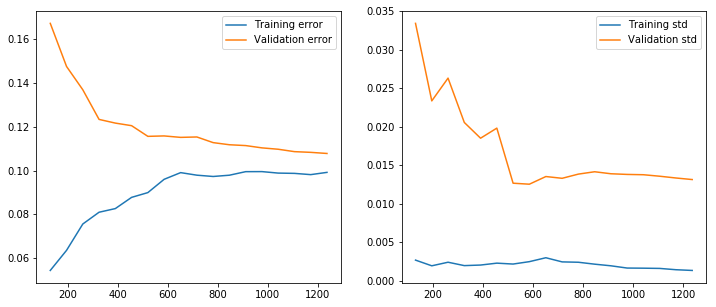

In [92]:
learning_print(best_lasso, butch_train, target, kfolds)

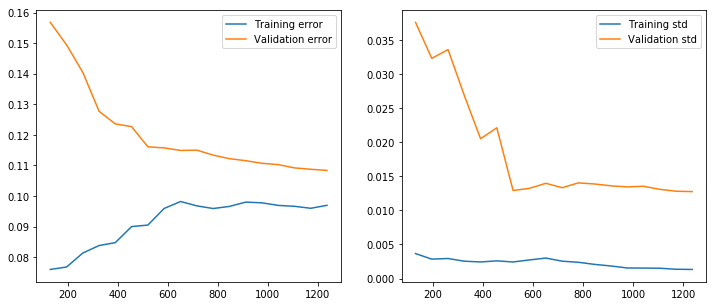

In [93]:
learning_print(best_ridge, butch_train, target, kfolds)

From these plots I can say the following:

* they learn very similarly
* Both have a bias around 0.1, which is about 4 times better than the baseline and I would consider it as low
* Both models would benefit if they could learn from more data (they 2 curves have still margin to converge)
* Ridge has more variance (the gap between the training and validation is bigger)

Since I can't get my hands on more data, I could try to increase the regularization and/or reduce the number of features (which would definitely increase the bias).

Let's give them a chance with a more accurate grid search. From all the previous steps I can narrow down the parameter space and make it more granular.

In [94]:
pipe = Pipeline([scl, ('lasso', Lasso(max_iter=2000))])

param_grid = [{'lasso__alpha' : np.arange(0.0001,0.001, 0.00001)}] #because it was always 0.0005

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_lasso = grid.best_estimator_
print(best_lasso)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
#print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 1.68 s, sys: 173 ms, total: 1.85 s
Wall time: 31.6 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.00035, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
________________________________________
0.10865769875


In [95]:
dol = get_dollars(best_lasso, kfolds, butch_train, target, old_target)
dol

12993.973

In [96]:
pipe = Pipeline([scl, ('ridge', Ridge())])

param_grid = [{'ridge__alpha' : np.arange(5,15,0.5)}]

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=kfolds, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

%time grid.fit(butch_train, target)

#let's see the best estimator
best_ridge = grid.best_estimator_
print(best_ridge)
print("_"*40)
#with its score
print(np.sqrt(-grid.best_score_))
print(pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score']])

CPU times: user 237 ms, sys: 32.1 ms, total: 269 ms
Wall time: 1.92 s
Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=7.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
________________________________________
0.109435328215
                    params  mean_test_score  std_test_score
0    {'ridge__alpha': 5.0}        -0.011994        0.002789
1    {'ridge__alpha': 5.5}        -0.011986        0.002790
2    {'ridge__alpha': 6.0}        -0.011981        0.002792
3    {'ridge__alpha': 6.5}        -0.011978        0.002795
4    {'ridge__alpha': 7.0}        -0.011976        0.002798
5    {'ridge__alpha': 7.5}        -0.011976        0.002801
6    {'ridge__alpha': 8.0}        -0.011977        0.002804
7    {'ridge__alpha': 8.5}        -0.011978        0.002808
8    {'ridge__alpha': 9.0}        -0.011981    

So according to my cv scores, I should decrease the regularization of Lasso a bit for a small improvement (not observable on the Leaderboard) and Ridge was already at its best.

# What I have learned and next steps

A total of 5 hours and a half have passed. I am out of ideas on how to get my models a better version of themselves without using more complicated and fancy algorithms. I feel it is a good moment to stop and think about what I have learned.

I always had the problem of finding something interesting in the data and dig into it with all the passion I have. This is **a lot** of fun (and we are all here for that) but more often than not I find myself spending 10 hours on something that will not help me solve the problem. 

This "agile" setting forced me to see a problem, ignore it for the time being, see how it goes, fix it in the next iteration. I felt way more productive and efficient because I was not getting distracted by the next problem that I was finding while fixing the previous one.

Moreover, I feel I had the chance of learning what can most likely help a model rather than not because I could see the effect of a single action in my results and thus it was easier to isolate that effect.

One thing that I am happy about is that my cross-validated scores are very reliable in predicting how the model will generalize (some fluctuations, but what doesn't fluctuate after all). The main reason for that is that I am careful of not use information I am not supposed to use. In other words, data leakage can help your public score (you can use the answers to help the question) but it won't make your model generalizable as you might think because it is easy to *overfit the test* .

The model here won't change the real estate industry but it is the product of half a day of work and we are talking about a very conservative industry. My concern with the data is that there are too many subjective features that get a lot of importance (Overall Quality above all) and these are not reliable in the long term unless the criteria are very strict.

This is a playground competition and this is, by any means, a game and an excuse to receive some feedback on how we can all do better. A few things came to my mind so far:

* I keep all the dummies and this can cause collinearity issues. It is true that we are talking about 2 regularized model and it should not matter too much, but it would be a good thing to check that.
* I didn't remove the skewness. Looking at other kernels and other experiments I did, a boxcox transformation would help. The one thing that I would do is to put the boxcox inside of the pipeline so that it doesn't use information of the validation set during cross-validation.
* Use a model like RandomForest to select the features. Again, inside of the pipeline. It would make it much slower but we spent already 5.5 hours in failing fast, we can try to fail slowly for once.
* Get fancy with ensemble and stacking models because it is a cool thing to do.

When I submitted my results, I got around the 550th position on the leaderboard (top 13%, kaggle said). The best score I got is 0.11727 and a top 100 result would be 0.114. One may evaluate in a realistic situation if that 0.003 of improvement in the mean squared error is worth the work that would require.

At last, here a summary of what happened in this kernel.

In [97]:
scoresummary = pd.DataFrame({'Model Name' : modelname,
                            'CVScore Lasso': lassoscore,
                            'CVScore Ridge': ridgescore,
                            'KaggleScore Lasso': kaggle_lasso,
                            'KaggleScore Ridge': kaggle_ridge,
                            'MAE Lasso': maecv_lasso,
                            'MAE Ridge': maecv_ridge,
                            'Cumulative Time': timeelapsed})

scoresummary[['Model Name', 'CVScore Lasso', 'CVScore Ridge', 'KaggleScore Lasso', 
             'KaggleScore Ridge', 'MAE Lasso', 'MAE Ridge', 'Cumulative Time']]

,Model Name,CVScore Lasso,CVScore Ridge,KaggleScore Lasso,KaggleScore Ridge,MAE Lasso,MAE Ridge,Cumulative Time
0,Baseline,0.1600,0.1600,0.41899,0.41899,55646.558,55646.558,600
1,Butcher,0.1499,0.1488,0.13321,0.13410,18544.430,18327.714,1800
2,Doc_Impute,0.1186,0.1185,0.11980,0.11974,14411.229,14495.809,9000
3,Impute_full,0.1115,0.1125,0.11847,0.11727,13250.529,13383.857,12600
4,Transform,0.1106,0.1114,0.11910,0.11838,13259.404,13375.657,16200
5,Feat_Sel_EDA,0.1099,0.1107,0.11953,0.11861,13161.658,13273.673,18000
6,Feat_eng,0.1089,0.1094,0.11928,0.11828,13027.341,13060.855,19800


At the very last, hope you have enjoyed and got some kind of inspiration (at the very least, inspired of *not* doing something) and I hope to receive some feedback from you.

Cheers.